# TEA-DT Community Pulse Check
## Full Results

In [759]:
# %% 
# Imports
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
from scipy.cluster.hierarchy import linkage, leaves_list, fcluster
from scipy.stats import chi2_contingency

In [760]:
# Define Plotting functions   
def melt_multiple_select(df, columns, new_col_name):
    flattened_df = pd.DataFrame()

    for col in columns:
        if df[col].apply(lambda x: isinstance(x, list)).any():
            # If the column contains lists, flatten them
            flat_col = df.explode(col).reset_index(drop=True)
            flattened_df = pd.concat([flattened_df, flat_col], axis=0)
        else:
            # If the column contains strings, just concatenate
            flattened_df = pd.concat([flattened_df, df[['_id', col]]], axis=0)
    
    # After all columns are processed, melt the DataFrame
    melted_df = flattened_df.melt(id_vars=['_id'], value_vars=columns, var_name='variable', value_name=new_col_name)

    # Drop rows where the value in new_col_name is NaN or empty
    melted_df = melted_df.dropna(subset=[new_col_name]).reset_index(drop=True)

    # Filter out entries where the column name contains "other" and the value is "Other"
    other_columns = [col for col in columns if 'other' in col.lower()]
    if other_columns:
        melted_df = melted_df[~(melted_df[new_col_name] == "Other")]


    return melted_df

def plot_pie_chart(df, category_col, title="Pie Chart", highlight=None, dpull=0, label_length=100, palette=None):
    df[category_col] = df[category_col].astype(str).str[:label_length]
    # Count the occurrences for each category
    counts = df[category_col].value_counts().reset_index()
    counts.columns = [category_col, 'count']
    
    # Determine which sections to highlight
    if highlight is None:
        pull = [dpull] * len(counts)
    else:
        if isinstance(highlight, str):
            highlight = [highlight]
        pull = [dpull if counts[category_col][i] in highlight else 0 for i in range(len(counts))]

    # Plot the pie chart
    fig = px.pie(counts, values='count', names=category_col, title=title,
                 color_discrete_sequence=palette)
    
    # Update layout to show labels outside the pie chart with leader lines
    fig.update_traces(textinfo='label', textposition='outside', showlegend=False,
                      marker=dict(line=dict(color='#000000', width=2)), pull=pull,
                      hole=0.3, textfont_size=12)

    # Add title and adjust margins
    fig.update_layout(title_text=title, title_x=0.5, margin=dict(t=50, b=0, l=0, r=0))
    
    return fig

def barplot_grouped(df, plot_val, group_by, group1, group2, category_order=None, color_palette=None):
    # Filter the DataFrame for the specified roles
    filtered_df = df[df[group_by].isin([group1, group2])]

    # Calculate the frequency counts
    freq_counts = filtered_df.groupby([plot_val, group_by]).size().unstack(fill_value=0).reset_index()

    # Calculate the total count of unique respondents for each group
    total_counts = df.groupby(group_by)['_id'].nunique()

    # Convert frequencies to percentages
    freq_counts[f'{group1}_percent'] = (freq_counts[group1] / total_counts[group1]) * 100
    freq_counts[f'{group2}_percent'] = (freq_counts[group2] / total_counts[group2]) * 100

    # Sort by difference in percentages
    freq_counts['diff'] = abs(freq_counts[f'{group1}_percent'] - freq_counts[f'{group2}_percent'])
    freq_counts = freq_counts.sort_values(by='diff', ascending=False)

    # Create a new DataFrame for plotting
    plot_df = pd.DataFrame({
        plot_val: pd.concat([freq_counts[plot_val], freq_counts[plot_val]]),
        group_by: [group1] * len(freq_counts) + [group2] * len(freq_counts),
        'Frequency': pd.concat([freq_counts[group1], freq_counts[group2]]),
        'Percentage': pd.concat([freq_counts[f'{group1}_percent'], freq_counts[f'{group2}_percent']])
    })

    # Create the bar plot
    fig = px.bar(plot_df, x=plot_val, y='Percentage', color=group_by, barmode='group',
                 title=f'Percentage Frequency of {plot_val} for {group_by} "{group1}" and "{group2}"',
                 hover_data={'Frequency': True},
                category_orders={plot_val: category_order},
                color_discrete_sequence=color_palette)

    # Update layout
    fig.update_layout(xaxis_title=plot_val, yaxis_title='Percentage')

    # Show the plot
    fig.show()
    
def barplot(df, plot_val, category_order=None, palette=None):
    # Calculate the total count of unique respondents (using _id)
    total_count = df['_id'].nunique()

    # Calculate the frequency counts
    freq_counts = df.groupby(plot_val)['_id'].nunique().reset_index()
    freq_counts.columns = [plot_val, 'Frequency']

    # Convert frequencies to percentages based on the total unique _id count
    freq_counts['Percentage'] = (freq_counts['Frequency'] / total_count) * 100
    # Sort by percentage
    freq_counts = freq_counts.sort_values(by='Percentage', ascending=True)

    # Create the bar plot using Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(data=freq_counts, y=plot_val, x='Percentage', palette=palette, order=category_order)

    # Customize the grid: remove horizontal lines but keep vertical ones
    plt.grid(axis='y', linestyle='')  # Remove horizontal lines
    plt.grid(axis='x', linestyle='-')  # Keep vertical lines
    # Update the layout
    plt.title(f'Percentage of {plot_val} based on Unique Respondents')
    plt.xlabel('Percentage')
    plt.ylabel(plot_val)
    plt.show()

def stacked_barplot(df, plot_val, group_by_dict, category_order=None, palette=None):
    # Create a new column in the DataFrame based on the group_by_dict
    df['Grouping'] = df[plot_val].map({val: key for key, vals in group_by_dict.items() for val in vals})
    
    # Calculate the frequency counts for each Grouping and plot_val combination
    freq_counts = df.groupby([plot_val, 'Grouping'])['_id'].nunique().reset_index()
    freq_counts.columns = [plot_val, 'Grouping', 'Frequency']

    # Sort the groupings by category order if provided
    if category_order is not None:
        freq_counts['Grouping'] = pd.Categorical(freq_counts['Grouping'], categories=category_order, ordered=True)

    # Pivot the data for a stacked bar plot
    freq_pivot = freq_counts.pivot_table(index='Grouping', columns=plot_val, values='Frequency', fill_value=0)
    
    fig = go.Figure()

    # Iterate through each group (index) in freq_pivot
    for group_idx, group in enumerate(freq_pivot.index):
        # Find columns with non-zero values for the current group
        non_zero_columns = freq_pivot.loc[group][freq_pivot.loc[group] > 0]
        
        # Sort the non-zero columns by value (descending order) for each group
        non_zero_columns = non_zero_columns.sort_values(ascending=False)
        
        # Assign colors based on the number of non-zero columns
        colors = palette[group_idx][:len(non_zero_columns)]
        
        # Plot the non-zero columns for this group, with sub-stacks sorted by size
        fig.add_trace(go.Bar(
            y=[group] * len(non_zero_columns),  # Repeat the group name for each non-zero column
            x=non_zero_columns.values,  # Frequencies for each non-zero column
            name=group,  # Group name
            orientation='h',
            text=non_zero_columns.index,  # Display column names on the sub-stacks
            textposition='auto',  # Automatically position the text
            marker=dict(color=colors),  # Assign the corresponding colors
            showlegend=group_idx == 0  # Show legend only for the first group
        ))

    # Update layout for better appearance
    fig.update_layout(
        barmode='stack',
        title='Count of Sub-items in Each Group',
        xaxis_title='Count',
        yaxis_title='Grouping',
        yaxis=dict(categoryorder='array', categoryarray=category_order),  # Apply the category order
        plot_bgcolor='rgba(0,0,0,0)',
        showlegend=True,
        legend_title_text='Sub-items'
    )

    # Show the plot
    fig.show()

def plot_role_frequencies(df, plot_val, group_by='role', sel1='Senior Management', sel2='Research and Development', category_order=None, palette=None):
    # Filter the DataFrame for the specified roles
    filtered_df = df[df[group_by].isin([sel1, sel2])]

    # Calculate the frequency counts
    freq_counts = filtered_df.groupby([plot_val, group_by]).size().unstack(fill_value=0).reset_index()

    # Calculate the total count of unique respondents for each group
    total_counts = df.groupby(group_by)['_id'].nunique()

    # Convert frequencies to percentages
    freq_counts[f'{sel1}_percent'] = (freq_counts[sel1] / total_counts[sel1]) * 100
    freq_counts[f'{sel2}_percent'] = (freq_counts[sel2] / total_counts[sel2]) * 100

    # Sort by difference in percentages
    freq_counts['diff'] = abs(freq_counts[f'{sel1}_percent'] - freq_counts[f'{sel2}_percent'])
    freq_counts = freq_counts.sort_values(by='diff', ascending=False)

    # Create a new DataFrame for plotting
    plot_df = pd.DataFrame({
        plot_val: pd.concat([freq_counts[plot_val], freq_counts[plot_val]]),
        group_by: [sel1] * len(freq_counts) + [sel2] * len(freq_counts),
        'Frequency': pd.concat([freq_counts[sel1], freq_counts[sel2]]),
        'Percentage': pd.concat([freq_counts[f'{sel1}_percent'], freq_counts[f'{sel2}_percent']])
    })

    # Create the bar plot
    fig = px.bar(plot_df, x=plot_val, y='Percentage', color=group_by, barmode='group',
                 title=f'Percentage Frequency of {plot_val} for {group_by} "{sel1}" and "{sel2}"',
                 hover_data={'Frequency': True},
                category_orders={plot_val: category_order},
                color_discrete_sequence=palette)

    # Update layout
    fig.update_layout(xaxis_title=plot_val, yaxis_title='Percentage')

    # Show the plot
    fig.show()


In [761]:
color_hex_codes = {
    # Blues
    "Cyan": "#00B4DF",        # 100% color
    "Cyan_25": "#40C7E7",     # 75% color, 25% white
    "Cyan_50": "#80D9EF",     # 50% color, 50% white
    "Cyan_75": "#BFECF7",      # 25% color, 75% white
    
    "Blue": "#0073B4",        # 100% color
    "Blue_25": "#4096C7",     # 75% color, 25% white
    "Blue_50": "#80B9DA",     # 50% color, 50% white
    "Blue_75": "#BFDCEC",     # 25% color, 75% white
    
    # Greens
    "Green": "#337538",       # 100% color
    "Green_25": "#66976A",    # 75% color, 25% white
    "Green_50": "#99BA9B",    # 50% color, 50% white
    "Green_75": "#CCDCCD",    # 25% color, 75% white
    
    "BlueGreen": "#009D72",        # 100% color
    "BlueGreen_25": "#40B595",     # 75% color, 25% white
    "BlueGreen_50": "#80CEB8",     # 50% color, 50% white
    "BlueGreen_75": "#BFE6DC",     # 25% color, 75% white

    "Teal": "#5DA899",        # 100% color
    "Teal_25": "#85BEB2",     # 75% color, 25% white
    "Teal_50": "#AED3CC",     # 50% color, 50% white
    "Teal_75": "#D6E9E5",     # 25% color, 75% white
    
    # Yellows
    "Yellow": "#CCBB40",      # 100% color
    "Yellow_25": "#D9CC70",   # 75% color, 25% white
    "Yellow_50": "#E5DD9F",   # 50% color, 50% white
    "Yellow_75": "#F2EECF",   # 25% color, 75% white
    
    "Lemon": "#F0E442",       # 100% color
    "Lemon_25": "#F4EB71",    # 75% color, 25% white
    "Lemon_50": "#F7F1A0",    # 50% color, 50% white
    "Lemon_75": "#FBF8D0",    # 25% color, 75% white
    
    # Oranges
    "Orange": "#E69F03",      # 100% color
    "Orange_25": "#ECB742",   # 75% color, 25% white
    "Orange_50": "#F2CF81",   # 50% color, 50% white
    "Orange_75": "#F9E7C0",   # 25% color, 75% white
    
    # Reds
    "Red": "#D45F14",         # 100% color
    "Red_25": "#DF874F",      # 75% color, 25% white
    "Red_50": "#E9AF89",      # 50% color, 50% white
    "Red_75": "#F4D7C4",      # 25% color, 75% white
    
    # Pinks
    "Pink": "#CC78A7",        # 100% color
    "Pink_25": "#D99ABD",     # 75% color, 25% white
    "Pink_50": "#E5BBD3",     # 50% color, 50% white
    "Pink_75": "#F2DDE9",     # 25% color, 75% white
    
    "Magenta": "#9F4A96",     # 100% color
    "Magenta_25": "#B777B0",  # 75% color, 25% white
    "Magenta_50": "#CFA4CA",  # 50% color, 50% white
    "Magenta_75": "#E7D2E5",  # 25% color, 75% white
    
    # Purples
    "Purple": "#812C55",      # 100% color
    "Purple_25": "#A06180",   # 75% color, 25% white
    "Purple_50": "#C095AA",   # 50% color, 50% white
    "Purple_75": "#DFC4D4",   # 25% color, 75% white
    
    # Grays
    "Gray": "#BBBBBB",        # 100% color
    "Gray_25": "#E8E8E8",     # 75% color, 25% white
}

def select_colors(total_items, primary_colors):

    # Calculate how many mixed colors are needed per primary color
    num_primary = len(primary_colors)
    num_mixed_per_primary = (total_items - num_primary) // num_primary
    
    if (total_items - num_primary) % num_primary != 0:
        num_mixed_per_primary += 1

    selected_colors = []
    
    # Iterate over each primary color in the specified list
    for color in primary_colors:
        selected_colors.append(color_hex_codes[color])
        if len(selected_colors) < total_items:
            if num_mixed_per_primary >= 1:
                selected_colors.append(color_hex_codes.get(f"{color}_25"))
            if num_mixed_per_primary >= 2 and len(selected_colors) < total_items:
                selected_colors.append(color_hex_codes.get(f"{color}_50"))
            if num_mixed_per_primary >= 3 and len(selected_colors) < total_items:
                selected_colors.append(color_hex_codes.get(f"{color}_75"))

    return selected_colors[:total_items]

# Example usage
#colors_for_6_items = select_colors(6, ['Cyan', 'Green', 'Yellow'])  # Select 3 primary colors and 1 mixed version for each


## Load Data

In [762]:
# Load Data
csv_file_path = 'tea_dt_data_full.csv'
df = pd.read_csv(csv_file_path)

### Summary Stats

In [763]:
print("Total number of responses:",df.shape[0])

df['time_spent_minutes'] = (pd.to_datetime(df['modification_date']) - pd.to_datetime(df['start_timestamp'])).dt.total_seconds() / 60.0
print("Mean duration spent on survey:", df['time_spent_minutes'].mean())

Total number of responses: 50
Mean duration spent on survey: 18.1


/var/folders/pf/qtjbydz94vv7r4pq8q1wxq980000gr/T/ipykernel_4580/2952236126.py:3: UserWarning:

Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.

/var/folders/pf/qtjbydz94vv7r4pq8q1wxq980000gr/T/ipykernel_4580/2952236126.py:3: UserWarning:

Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.



### Preprocessing

In [764]:
# cleaning cells
def split_at_parentheses(text):
    if isinstance(text, str):
        return text.split('(')[0].strip()
    return text

def melt_multiple_select(df, columns, new_col_name):
    melted_df = df.melt(id_vars=['_id'], value_vars=columns, var_name='variable', value_name=new_col_name).dropna(subset=[new_col_name])
    return melted_df

def merge_columns(df, columns):
    """
    Merges multiple columns into a single list column, 
    excluding 'Other' across all columns if any column contains 'other' in its name.
    
    Parameters:
    df (DataFrame): The DataFrame containing the columns to merge.
    columns (list): List of columns to merge.
    
    Returns:
    Series: A pandas Series containing the merged lists.
    """
    # Check if any column name contains 'other'
    contains_other = any('other' in col.lower() for col in columns)
    
    return df[columns].apply(
        lambda row: [
            item for item in row 
            if pd.notna(item) and not (contains_other and item == "Other")
        ],
        axis=1
    )

df = df.map(split_at_parentheses)

In [765]:
# Re-code "Other" entries

# Step 1: Merge all columns that are 'select_all' and had "specify other" option
select_all_cols = ['type_dt','purpose_dt','assurance_mechanism','assured_properties','support_for_assurance']

for col_name in select_all_cols:
    df[f'{col_name}_combined'] =  merge_columns(df, [col for col in df.columns if col.startswith(col_name)])

#Step2 2: re-code "other" entries
replace_type_dict={
    'Patient DT': "Patient",
    'Digital twins of patient organs/systems': "Patient",
    'Interconnections between 3rd party digital twins': "Connectivity",
    'We have developed Digital Twin system for Offshore Energy Floating Offshore Wind, Wave Energy and Oil &Gas': np.nan,
    'Maritime': np.nan,
    'We are building a universal connected and semantic digital twin called The World Avatar':["Semantic", "Connectivity"],
    'Product Digital Twin for an Extra Large Autonomous Underwater Vehicle': "Physical asset",
    'Emissions, predictive health monitoring, LCA, logistics': np.nan, #this respondent selected categories AND filled in "Other" ,
 }
df['type_dt_combined'] = df['type_dt_combined'].apply(lambda x: [replace_type_dict.get(item, item) for item in x] )


replace_purpose_dict={
    'any purpose from atomic to planetary the digital twin is not related to a specific application but aims to represent any application.':
        ["Internal Operations","External Collaboration","Public Impact", "Market / Customer Engagement", "Research and Development"],    
}
df['purpose_dt_combined'] = df['purpose_dt_combined'].apply(lambda x: [replace_purpose_dict.get(item, item) for item in x] )


replace_mechanisms_dict={
    'all of the aspects metioned': ["Bias Reviews", "Compliance Audits", "Conformity Assessments", "Stakeholder Feedback Systems","Risk Assessment", "Impact Assessment", "Information Security Reviews",
                                    "Data Quality Checks", "Formal Verification", "Post-Implementation Evaluation", "Service Continuity Management", "Performance Monitoring", "Operational Audits", "Service Quality Reviews"],
    'Extensive governance and oversight throughout the lifecycle of a project.': ["Governance", "Oversight"],
    'What’s appropriate to the purpose intended': np.nan,
    'Claims based assurance - reviewing evidence to validate specific claims about the performance and operations of a Digital Twin.\\nMaturity Assessment - assessing the maturity of the organisation and their ability to manage and maintain DTs.': ['Claims-based assurance', 'Maturity assessment'],
}
df['assurance_mechanism_combined'] = df['assurance_mechanism_combined'].apply(lambda x: [replace_mechanisms_dict.get(item, item) for item in x] )


replace_properties_dict={
    'Digital twinning technology is different from digital twin, like a bucket is different from the water it contains. When selecting or assuring the technology I would assure myself that the requirements are clear, understood and that the technology provided meets those requirements.': ["Fit-for-purpose", "Transparency"],
    'all of the aspects mentioned': ["Accountability", "Contestability","Data Quality","Data Stewardship","Ethical Integrity","Evolution","Explainability","Fairness","Federation","Financial Performance","Fit-for-purpose",
            "Governance","Interoperability","Openness","Public Good","Reliability/Robustness","Resilience / Fault-tolerance","Safety","Security","Sustainability","Transparency","Trustworthiness","Value Creation",]
}
df['assured_properties_combined'] = df['assured_properties_combined'].apply(lambda x: [replace_properties_dict.get(item, item) for item in x] )


replace_support_dict={
    'We are a micro enterprise': np.nan,
    'I work on structured arguments': np.nan
}
df['support_for_assurance_combined'] = df['support_for_assurance_combined'].apply(lambda x: [replace_support_dict.get(item, item) for item in x] )


In [766]:
for column_name in select_all_cols:
    df[f'{column_name}_combined'] = df[f'{column_name}_combined'].apply(
    lambda x: np.nan if not any(x) else [item for sublist in x for item in (sublist if isinstance(sublist, list) else [sublist])]
)

## Community Composition

In [767]:
percentage_uk = round((df['location'].value_counts(normalize=True)['United Kingdom']) * 100)

print(f'We have received {df.shape[0]} responses from representatives across {df['sector'].nunique()} different sectors.\n',
'This diverse participation reflects the growing trend towards the broad adoption of digital twinning technology.\n')
print(f'The majority of the organizations participating in our survey are based in the UK ({percentage_uk}%), as we primarily reached out to UK networks.\nHowever, we also received responses from organizations in a total of {df['location'].nunique()} countries, demonstrating some wider global representation.\n')
df.groupby('location')['_id'].count()

We have received 50 responses from representatives across 19 different sectors.
 This diverse participation reflects the growing trend towards the broad adoption of digital twinning technology.

The majority of the organizations participating in our survey are based in the UK (66%), as we primarily reached out to UK networks.
However, we also received responses from organizations in a total of 10 countries, demonstrating some wider global representation.



location
France                   1
Germany                  1
Global                   8
Italy                    1
Japan                    1
Singapore                1
South Africa             1
United Arab Emirates     1
United Kingdom          33
United States            2
Name: _id, dtype: int64

In [768]:
print(f'The majority of respondents reported their roles to be within Research and Development, Senior Management or as Strategic/Business Leads. \nAdditional roles reported, include in-house Technical Specialist, Digital Twin Support Specialists and Consultants/External Specialists.')
df.groupby('role')['_id'].count()

The majority of respondents reported their roles to be within Research and Development, Senior Management or as Strategic/Business Leads. 
Additional roles reported, include in-house Technical Specialist, Digital Twin Support Specialists and Consultants/External Specialists.


role
Consultant/External Specialist      5
Digital Twin Support Specialist     1
In-house Technical Specialist       7
Other                               2
Research and Development           17
Senior Management                  10
Strategic/Business Lead             8
Name: _id, dtype: int64

In [769]:
print(f'However, across roles, some respondents shared similar primary responsibilities.')
print('For example, individuals in Research and Development roles frequently reported responsibilities beyond Research and Innovation, including Strategic Direction and Technical Decision-Making.')
print('Similarly, individuals in Senior Management roles reported to be invovled in Technical Decision-Making and Strategic Leads most often selected Research and innovation as their primary responsibility.')

# create similarity matrix to compare groups of 'roles' according to what 'responsbilities' they have
responsibility_columns = [col for col in df.columns if col.startswith('primary_responsibilities')]
responsibility_melted = melt_multiple_select(df, responsibility_columns, 'primary_responsibilities',)
merged_data = pd.merge(df[df['role'].isin(['Research and Development', 'Senior Management','Strategic/Business Lead','In-house Technical Specialist'])][['_id','role']], responsibility_melted, on='_id')
role_responsibility_matrix = pd.crosstab(merged_data['role'], merged_data['primary_responsibilities'])
role_responsibility_matrix

However, across roles, some respondents shared similar primary responsibilities.
For example, individuals in Research and Development roles frequently reported responsibilities beyond Research and Innovation, including Strategic Direction and Technical Decision-Making.
Similarly, individuals in Senior Management roles reported to be invovled in Technical Decision-Making and Strategic Leads most often selected Research and innovation as their primary responsibility.


primary_responsibilities,Budget Management,Ensuring Compliance,Governance Influence,Operational Management,Other,Project Leadership,Research and Innovation,Strategic Direction,Technical Decision-Making
role,,,,,,,,,
In-house Technical Specialist,0,1,1,2,0,2,3,2,5
Research and Development,0,0,0,0,2,5,14,6,5
Senior Management,1,1,1,2,1,3,3,7,5
Strategic/Business Lead,1,1,2,2,0,4,5,3,3


In [770]:
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

# Identify all columns starting with "primary_responsibility["
responsibility_columns = [col for col in df.columns if col.startswith('primary_responsibilities[')]

# Convert each row to a set of responsibilities
responsibility_sets = df[responsibility_columns].apply(lambda row: set(row.dropna()), axis=1)

# Compute the Jaccard similarity matrix
n = len(responsibility_sets)
similarity_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(i, n):
        similarity = jaccard_similarity(responsibility_sets[i], responsibility_sets[j])
        similarity_matrix[i, j] = similarity
        similarity_matrix[j, i] = similarity  # Symmetric matrix

In [771]:
# Step 1: Perform hierarchical clustering
linked = linkage(similarity_matrix, method='ward')

# Step 2: Get the order of the leaves (i.e., the order of the responses based on clustering)
order = leaves_list(linked)

# Step 3: Reorder the similarity matrix based on the clustering
sorted_similarity_matrix = similarity_matrix[order][:, order]

# Step 4: Get the '_id' and 'role' in the new order
sorted_ids = df['_id'].values[order]
sorted_roles = df['role'].values[order]
df['responsibilities'] = responsibility_sets


In [772]:
# Step 1: Perform hierarchical clustering
linked = linkage(similarity_matrix, method='ward')
# Step 2: Get the '_id' and 'role' in the original order
roles = df['role'].values

# Step 3: Plot the dendrogram with these labels
plt.figure(figsize=(12, 8))

# Create the dendrogram
thresh =5
df['cluster_id'] = fcluster(linked, t=thresh, criterion='maxclust')

<Figure size 1200x800 with 0 Axes>

In [773]:
# Loop through each unique cluster_id
for cluster_id, group in df.groupby('cluster_id'):
    responsibilities_sets = group['responsibilities']
    
    # Count the number of rows in this cluster
    row_count = len(group)
    
    # Initialize a Counter for the responsibilities
    combined_counter = Counter()
    
    # Update the counter with all sets in the current cluster_id
    for responsibilities_set in responsibilities_sets:
        combined_counter.update(responsibilities_set)
    
    # Print the results for the current cluster_id
    print(f"Cluster {cluster_id}: {row_count} responses")
    print(combined_counter)
    print() 

Cluster 1: 14 responses
Counter({'Research and Innovation': 14, 'Project Leadership': 3, 'Other': 2, 'Governance Influence': 1, 'Ensuring Compliance': 1})

Cluster 2: 12 responses
Counter({'Research and Innovation': 12, 'Technical Decision-Making': 11, 'Strategic Direction': 9, 'Project Leadership': 6, 'Governance Influence': 1})

Cluster 3: 7 responses
Counter({'Strategic Direction': 7, 'Operational Management': 1, 'Ensuring Compliance': 1, 'Governance Influence': 1})

Cluster 4: 5 responses
Counter({'Project Leadership': 5, 'Operational Management': 1})

Cluster 5: 12 responses
Counter({'Technical Decision-Making': 11, 'Project Leadership': 6, 'Strategic Direction': 5, 'Operational Management': 4, 'Ensuring Compliance': 3, 'Governance Influence': 3, 'Research and Innovation': 3, 'Budget Management': 2, 'Other': 2})



The data revealed a mixture of highly specialized and multi-functional roles, along with a strong representation of leadership positions. 
- Two specialized groups, one focusing either on Research and Innovation (but not technical or strategic decision making), and one focusing on project leadership or strategic direction (but not research and innovation or technical development)
- Two groups with mixed responsibilities, focusing either on Research and Technical decision making (but not Strategy) or Technical and Strategic decision making.
 
- Noteworthy: Only 4 responses selected 'Compliance' as their reseponsibility. Most of those, in addition to compliance are balancing a wide range of responsibilities, including technical decision making and operational management.

Overall The data indicates that about half of the respondents respondents have a broad range of responsibilities that span multiple functions, suggesting smaller, multi-functional teams as often typical in relatively immature sectors. 

### Add Grouping Based on Community Composition
Implement grouping based on responses for
- location (uk/nonuk)
- set of responsibilities
- internal vs external purpose

In [774]:
# Code groupings
# create new column with binary grouping based on location
df['uk/nonuk'] = df['location'].apply(lambda x: 'uk' if x in ["United Kingdom"] else 'non-uk')
# create new column with cluster-based grouping of role focus based on response to 'primary_responsibilities'
df.rename(columns={'cluster_id': 'role_focus'}, inplace=True)
group_labels = {
    1: "Research-Focused",
    2: "Research and Technical",
    3: "Leadership and Strategic",   # Combine Cluster 4 & 5
    4: "Leadership and Strategic",  # Combine Cluster 4 & 5
    5: "Technical and Strategic",
}
df['role_focus'] = df['role_focus'].map(group_labels)

# create new column grouping purpose into external vs internal
df['purpose_focus'] = df['purpose_dt_combined'].apply(
    lambda row: 'external' 
    if isinstance(row, list) and any(val in ["Public Impact", "External Collaboration", "Market / Customer Engagement"] for val in row) 
        else ('internal' if isinstance(row, list) 
          else np.nan)
)

In [775]:
df['purpose_dt_combined']

0                            [Research and Development]
1             [Public Impact, Research and Development]
2                            [Research and Development]
3                                       [Public Impact]
4                                                   NaN
5     [Market / Customer Engagement, Research and De...
6                                       [Public Impact]
7     [Internal Operations, External Collaboration, ...
8     [Research and Development, Internal Operations...
9     [Research and Development, External Collaborat...
10        [Internal Operations, External Collaboration]
11        [Internal Operations, External Collaboration]
12                                [Internal Operations]
13                                      [Public Impact]
14                           [Research and Development]
15    [Internal Operations, Market / Customer Engage...
16    [Internal Operations, Market / Customer Engage...
17                                [Internal Oper

In [776]:
print(f'We therefore grouped them based on similarity in responsibilities, identifying {df['role_focus'].nunique()} main groups {df['role_focus'].unique()}')
plot_pie_chart(df, 'role_focus')

We therefore grouped them based on similarity in responsibilities, identifying 4 main groups ['Research-Focused' 'Technical and Strategic' 'Research and Technical'
 'Leadership and Strategic']


In [777]:
# Generate the individual figures
pie_location = plot_pie_chart(df, 'uk/nonuk')
pie_focus = plot_pie_chart(df, 'purpose_focus')

# Create a subplot figure with 1 row and 2 columns
# Create a grid of 4 rows and 2 columns for the plots with domain type subplots for pie charts
fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'domain'}, {'type': 'domain'}]],
                   subplot_titles=("Location", "Purpose"))

# Add traces from the individual figures to the subplot
fig.add_trace(pie_location['data'][0], row=1, col=1)
fig.add_trace(pie_focus['data'][0], row=1, col=2)
mycolor = select_colors(3, ['Blue', 'Teal', 'Yellow'])
fig.update_traces(marker=dict(colors=mycolor), row=1, col=1)
mycolor = select_colors(3, ['Pink', 'Red', 'Gray_25'])
fig.update_traces(marker=dict(colors=mycolor), row=1, col=2)


# Update layout
fig.update_layout(title_text="New Groupings", height=1200, width=1000, margin=dict(t=100, l=50, r=50, b=100))
# Show the combined figure
fig.show()


In [778]:
# Chi-square test for independence to check if one grouping may be confounding another
# List of the three categorical columns
categories = ['uk/nonuk', 'role_focus', 'purpose_focus','Assurance_experience']

results = []

# Pairwise Chi-Square Test for each pair of columns
for i in range(len(categories)):
    for j in range(i + 1, len(categories)):
        # Create a contingency table for the two categories
        contingency_table = pd.crosstab(df[categories[i]], df[categories[j]])

        # Chi-Square Test
        chi2, p, dof, expected = chi2_contingency(contingency_table)

        results.append((categories[i], categories[j], chi2, p))

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results, columns=['Category 1', 'Category 2', 'Chi2', 'p-value'])

print(results_df)
# Interpretation: If p-value < 0.05, it suggests the pair is likely confounded


      Category 1            Category 2       Chi2   p-value
0       uk/nonuk            role_focus   7.983193  0.046360
1       uk/nonuk         purpose_focus   2.921516  0.232060
2       uk/nonuk  Assurance_experience   3.251558  0.354442
3     role_focus         purpose_focus  10.050595  0.122537
4     role_focus  Assurance_experience   4.649663  0.863717
5  purpose_focus  Assurance_experience   6.445893  0.375135


## Current Practices

RQ1: - What are the current assurance practices implemented in the digital twinning space?

Insights Summary:
- Participants report a range of assurance techniques with **Data Quality Checks** being the **most frequently** chosen across roles
- There are differences in which & ho many assurance techniques are considered by people in leadership and strategic roles vs people with a research-only focus:
    - **Performance Montioring** and **Conformity Assessment** reported by the majority of people in leaderhsip or strategic roles.
- Across all responses a wide range of properties is currently assured for:
    - **Data Quality**, **Interoperability** and **Fit-for-purpose** was reported **by more than half** of respondents **across roles**
    - In addition, **Resilience**, **Trustworthiness** and **Reliability** were chosen more frequently by people in leadership and strategic roles compared to research-focused roles. Vice-versa for **explainability**
- Most assurance activities are conducted **in-house** and through **non-specialized teams**
- **More than half** of all respondents **consider sharing** data or models with others to form **connected digital twins**, the majority of which found it **difficult to establish trust** in this context
    - While **a large majority** (88%) rely on assurance to some extent to build trust, **only few** do so to a strong degree (26%)

### What do you understand ‘assurance’ to mean in the context of your work in the digital twinning sector?"

In [779]:
# Display a subset of columns
display(df[['assurance_meaning']].head(5))

# count number of words in df
cells = df['assurance_meaning'].values.flatten()
word_counts = [len(str(cell).split()) for cell in cells]
print(f"Minimum number of words: {min(word_counts)}")
print(f"Maximum number of words: {max(word_counts)}")
print(f"Average number of words: {sum(word_counts) / len(word_counts):.2f}")

,assurance_meaning
0,Assurance means digital twins are trustworthy
1,Reproducibility and accuracy of the DT
2,It means the digital twins should be explainab...
3,Assurance is the process and mechanisms by whi...
4,To provide security about a certain topic like...


Minimum number of words: 1
Maximum number of words: 95
Average number of words: 22.18


In [780]:
# analysis of content tags will follow here ...

### Which of the following assurance mechanisms do you **currently** rely on for your own (or your client's) digital twin(s)?

In [781]:
avg_number_mechanism = df['assurance_mechanism_combined'].apply(lambda x: len(x) if isinstance(x, list) else 0).mean()
std_number_mechanism = df['assurance_mechanism_combined'].apply(lambda x: len(x) if isinstance(x, list) else 0).std()
print(f'on average, respondents selected {np.round(avg_number_mechanism)} (std={np.round(std_number_mechanism)}) different assurance mechanisms to be currenlty applied by them.')


on average, respondents selected 5.0 (std=3.0) different assurance mechanisms to be currenlty applied by them.


In [782]:
df['mechanism_count'] = df['assurance_mechanism_combined'].apply(lambda x: len(x) if isinstance(x, list) else 0)
# Create a histogram and calculate the cumulative distribution
hist_values, bin_edges = np.histogram(df['mechanism_count'], bins=range(1, df['mechanism_count'].max() + 2))
cumulative_counts = np.cumsum(hist_values)

# Find the value where the cumulative count reaches 50% or more
majority_value = bin_edges[np.argmax(cumulative_counts >= cumulative_counts[-1] / 2)]

# Print the insight
print(f"The majority of people choose {majority_value} assurance mechanisms or less to be currently applied by them.")

The majority of people choose 4 assurance mechanisms or less to be currently applied by them.


The most frequently applied assurance mechanisms were ['Data Quality Checks' 'Risk Assessment' 'Stakeholder Feedback Systems']
The least selected assurance mechanisms were ['Service Continuity Management' 'Bias Reviews' 'Governance' 'Oversight'
 'Claims-based assurance' 'Maturity assessment']


/var/folders/pf/qtjbydz94vv7r4pq8q1wxq980000gr/T/ipykernel_4580/3208317428.py:110: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




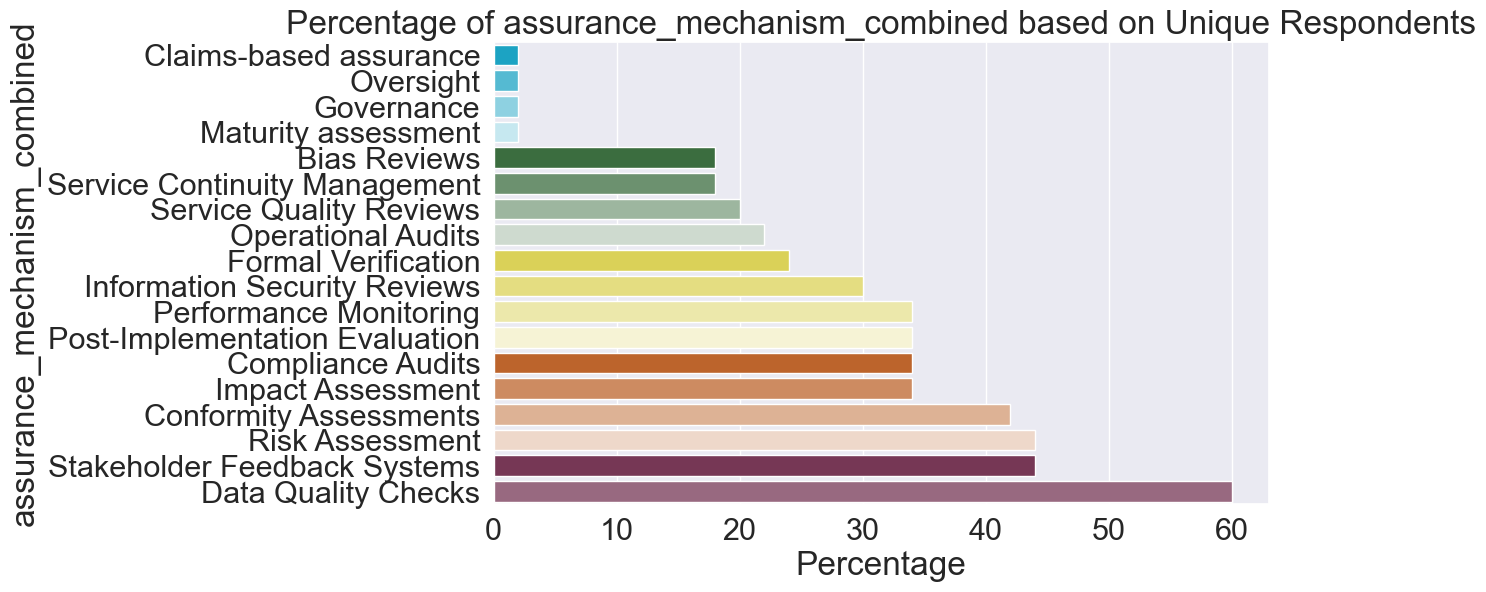

In [783]:
df_exploded = df.explode('assurance_mechanism_combined').reset_index(drop=True)
df_exploded['assurance_mechanism_combined'].value_counts()[:3]

top_3_mechanisms = df_exploded['assurance_mechanism_combined'].value_counts()[:3]
print(f'The most frequently applied assurance mechanisms were {top_3_mechanisms.index.values}')
top_3_mechanisms = df_exploded['assurance_mechanism_combined'].value_counts()[-6:]
print(f'The least selected assurance mechanisms were {top_3_mechanisms.index.values}')

mycolor = select_colors(18, ["Cyan", "Green", "Lemon", "Red", "Purple"])
barplot(df_exploded, 'assurance_mechanism_combined',palette=mycolor)

In [787]:
df_exploded = df.explode('assured_properties_combined').reset_index(drop=True)


In [788]:
# Example usage:
group_properties = {
    'Technical Performance': [
        'Data Quality', 'Reliability/Robustness', 'Security', 
        'Resilience/ Fault tolerance', 'Data Stewardship', 'Accuracy'
    ],
    'Ecosystem Integration': [
        'Interoperability', 'Evolution', 'Federation'
    ],
    'Ethical': [
        'Explainability', 'Ethical Integrity', 'Sustainability', 
        'Fairness', 'Social Justice'
    ],
    'Societal': [
        'Openness', 'Safety', 'Public Good', 'Trustworthiness'
    ],
    'Economic': [
        'Fit-for-purpose', 'Financial Performance', 'Value Creation', 'Sustainability'
    ],
    'Legal & Regulatory': [
        'Governance', 'Contestability', 'Transparency', 'Accountability'
    ]
}

# Define the primary colors to be used for each group
primary_colors = [
    ["#5DA899", "#85BEB2", "#AED3CC", "#D6E9E5"],  # Teal
    ["#337538", "#66976A", "#99BA9B", "#CCDCCD"],  # Greens
    ["#D9CC70", "#F4EB71", "#F7F1A0", "#FBF8D0"],  # Yellow
    [ "#E69F03", "#ECB742", "#F2CF81", "#F9E7C0"],# Oranges
    ["#812C55",'#B777B0','#CFA4CA','#E7D2E5'], #Purples
    ["#4096C7", "#40C7E7", "#80D9EF","#BFECF7"]  #Blues
]

stacked_barplot(df_exploded, 'assured_properties_combined', group_properties, category_order=['Ecosystem Integration','Legal & Regulatory','Ethical','Societal','Economic','Technical Performance'], palette=primary_colors)


/var/folders/pf/qtjbydz94vv7r4pq8q1wxq980000gr/T/ipykernel_4580/3208317428.py:134: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



In [ ]:
# Specify the two roles
select_from = 'role_focus'
sel1 = 'Research-Focused'
sel2 = 'Leadership and Strategic'
plot_val = 'mechanism'

# Melt columns
df_exploded = df.explode('assurance_mechanism_combined').reset_index(drop=True)
mycolor = select_colors(2, ["Cyan", "Green"])
plot_role_frequencies(df_exploded, 'assurance_mechanism_combined', select_from, sel1, sel2, palette=mycolor)


Some assurance mechanisms where noticable more often selected by one group compared to another.
For example, Conformity Assessment & Performance Monitoring were more often reported to be used by leadership and strategic roles compared to Research-focused roles. Compliance Audits and Formal Verification were not at all reported by Research-focused roles.

This illustrates how different aspects of assurance are distributed onto different roles and motivates the need for a tool that allows these different types of assurance to be converged into one holistic narrative

/var/folders/pf/qtjbydz94vv7r4pq8q1wxq980000gr/T/ipykernel_4580/101428424.py:110: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




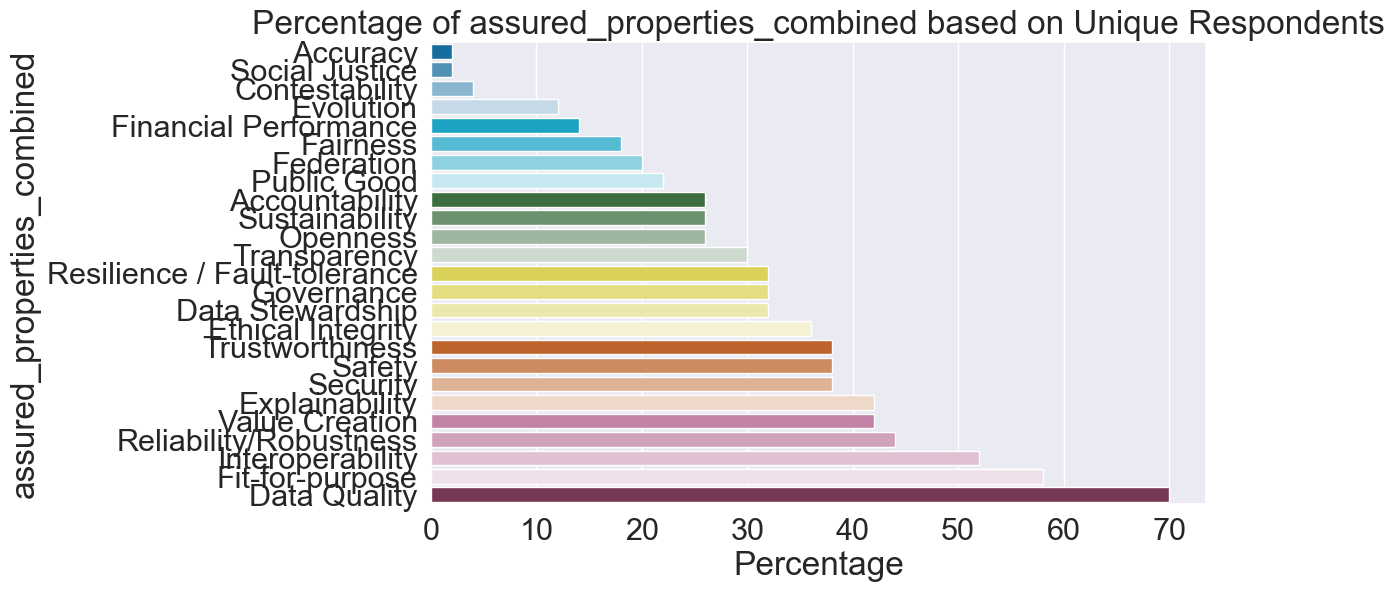

In [ ]:
df_exploded = df.explode('assured_properties_combined').reset_index(drop=True)
mycolor = select_colors(25, ["Blue","Cyan", "Green", "Lemon","Red", "Pink","Purple"])
barplot(df_exploded, 'assured_properties_combined', palette=mycolor)

In [ ]:
# Count how often 'Data Quality' and 'Data Stewardship' co-occur
co_occurrence_count = sum(
    {'Data Quality', 'Data Stewardship'}.issubset(set(items)) 
    for items in df['assured_properties_combined'] 
    if isinstance(items, list)
)

# Count how often 'Data Stewardship' appears alone
data_stewardship_only_count = (df_exploded['assured_properties_combined']=='Data Stewardship').sum()

print(f"'Data Quality' and 'Data Stewardship' co-occur: {co_occurrence_count} times")
print(f"'Data Stewardship' appears overall: {(df_exploded['assured_properties_combined']=='Data Stewardship').sum()} times")
print(f"'Data Quality' appears overall: {(df_exploded['assured_properties_combined']=='Data Quality').sum()} times")

# delete rows from df_exploded tthat contain 'Data Stewardship' and 'Data Quality' within same '_id'
ids_with_data_quality = df_exploded[df_exploded['assured_properties_combined'] == 'Data Quality']['_id'].unique()
df_exploded = df_exploded[~((df_exploded['_id'].isin(ids_with_data_quality)) & 
                            (df_exploded['assured_properties_combined'] == 'Data Stewardship'))]
df_exploded.loc[df_exploded['assured_properties_combined'] == 'Data Stewardship', 'assured_properties_combined'] = 'Data Quality'

'Data Quality' and 'Data Stewardship' co-occur: 15 times
'Data Stewardship' appears overall: 16 times
'Data Quality' appears overall: 35 times


In [ ]:
# Example usage:
group_properties = {
    'Technical Performance': [
        'Data Quality', 'Reliability/Robustness', 'Security', 
        'Resilience/ Fault tolerance', 'Data Stewardship', 'Accuracy'
    ],
    'Ecosystem Integration': [
        'Interoperability', 'Evolution', 'Federation'
    ],
    'Ethical': [
        'Explainability', 'Ethical Integrity', 'Sustainability', 
        'Fairness', 'Social Justice'
    ],
    'Societal': [
        'Openness', 'Safety', 'Public Good', 'Trustworthiness'
    ],
    'Economic': [
        'Fit-for-purpose', 'Financial Performance', 'Value Creation', 'Sustainability'
    ],
    'Legal & Regulatory': [
        'Governance', 'Contestability', 'Transparency', 'Accountability'
    ]
}

# Define the primary colors to be used for each group
primary_colors = [
    ["#5DA899", "#85BEB2", "#AED3CC", "#D6E9E5"],  # Teal
    ["#337538", "#66976A", "#99BA9B", "#CCDCCD"],  # Greens
    ["#D9CC70", "#F4EB71", "#F7F1A0", "#FBF8D0"],  # Yellow
    [ "#E69F03", "#ECB742", "#F2CF81", "#F9E7C0"],# Oranges
    ["#812C55",'#B777B0','#CFA4CA','#E7D2E5'], #Purples
    ["#4096C7", "#40C7E7", "#80D9EF","#BFECF7"]  #Blues
]

stacked_barplot(df_exploded, 'assured_properties_combined', group_properties, category_order=['Ecosystem Integration','Legal & Regulatory','Ethical','Societal','Economic','Technical Performance'], palette=primary_colors)


/var/folders/pf/qtjbydz94vv7r4pq8q1wxq980000gr/T/ipykernel_4580/101428424.py:135: FutureWarning:

The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior



Possible grouping for better visualisation suggested by CB
- **Technical Performance**: Data Quality, Reliability/Robustness, Security, Resilience/ Fault tolerance, Data Stewardship, Accuracy
- **Ecosystem Integration**: Interoperability, Evolution, Federation
- **Ethical**: Explainability, Ethical Integrity, Sustainability, Fairness, Social Justice
- **Societal**: Openness, Safety, Public Good, Trustworthiness
- **economic**: Fit-for-purpose, Financial Performance, Value Creation, Sustainability
- **Legal**: Governance, Contestability, Transparency, Accountability


In [ ]:
# Specify the two roles
select_from = 'role_focus'
sel1 = 'Research-Focused'
sel2 = 'Leadership and Strategic'
plot_val = 'assured_properties_combined'

# Melt columns
plot_role_frequencies(df_exploded, plot_val, select_from, sel1, sel2)

In [ ]:
avg_number_property = df['assured_properties_combined'].apply(lambda x: len(x) if isinstance(x, list) else 0).mean()
std_number_property = df['assured_properties_combined'].apply(lambda x: len(x) if isinstance(x, list) else 0).std()
print(f'on average, respondents selected {np.round(avg_number_property)} (std={np.round(std_number_property)}) different properties currently assured for by them.')

on average, respondents selected 8.0 (std=5.0) different properties currently assured for by them.


In [ ]:
df['properties_count'] = df['assured_properties_combined'].apply(lambda x: len(x) if isinstance(x, list) else 0)
# Create a histogram and calculate the cumulative distribution
hist_values, bin_edges = np.histogram(df['properties_count'], bins=range(1, df['properties_count'].max() + 2))
cumulative_counts = np.cumsum(hist_values)

# Find the value where the cumulative count reaches 50% or more
majority_value = bin_edges[np.argmax(cumulative_counts >= cumulative_counts[-1] / 2)]

# Print the insight
print(f"The majority of people choose {majority_value} properties or less currently assured for by them.")

The majority of people choose 7 properties or less currently assured for by them.


In [ ]:
top_3_properties = df_exploded['assured_properties_combined'].value_counts()[:3]
print(f'The most frequently considered properties were {top_3_properties.index.values}')

The most frequently considered properties were ['Data Quality' 'Fit-for-purpose' 'Interoperability']


In [ ]:
top_3_properties = df_exploded['assured_properties_combined'].value_counts()[-3:]
print(f'The properties least considered during assurance were {top_3_properties.index.values}')

The properties least considered during assurance were ['Contestability' 'Accuracy' 'Social Justice']


In [ ]:
barplot_grouped(df_exploded, 'assured_properties_combined', select_from, sel1, sel2)

Properties such as Fit-for-purpose, Resilience and Data Quality are more often considered by Leadership and Strategic roles, whereas Research-Focused roles care more about Explainability

In [ ]:
# WIP: does this make sense to pair up properties and mechanisms?
property_mechanism_map = {
    "Fairness": ["Bias Reviews"],
    "Governance": ["Compliance Audits", "Operational Audits"],
    "Accountability": ["Compliance Audits", "Stakeholder Feedback Systems", "Post-Implementation Evaluation"],
    "Fit-for-purpose": ["Conformity Assessments", "Formal Verification", "Operational Audits"],
    "Reliability/Robustness": ["Conformity Assessments", "Formal Verification", "Service Continuity Management", "Service Quality Reviews"],
    "Transparency": ["Stakeholder Feedback Systems", "Data Quality Checks"],
    "Explainability": ["Stakeholder Feedback Systems"],
    "Resilience / Fault-tolerance": ["Risk Assessment", "Service Continuity Management"],
    "Safety": ["Risk Assessment"],
    "Security": ["Risk Assessment", "Information Security Reviews"],
    "Public Good": ["Impact Assessment"],
    "Sustainability": ["Impact Assessment"],
    "Value Creation": ["Impact Assessment", "Service Quality Reviews"],
    "Data Quality": ["Data Quality Checks"],
    "Trustworthiness": ["Information Security Reviews", "Data Quality Checks"],
}

In [ ]:
## Check if properties were selected together with their corresponding mechanisms
def check_assurance(row, property_mechanism_map, row_number, failed_checks):
    assured_properties = row['assured_properties_combined']
    assurance_mechanisms = row['assurance_mechanism_combined']
    
    if not isinstance(assured_properties, list) or not isinstance(assurance_mechanisms, list):
        return False  # Skip rows that don't contain lists
    
    for key in assured_properties:
        if key in property_mechanism_map:
            required_mechanisms = property_mechanism_map[key]
            if not any(mechanism in assurance_mechanisms for mechanism in required_mechanisms):
                failed_checks.append((key, row_number))  # Log the property and row number
                return False
    return True

# List to hold failed checks of the form (property, row_number)
failed_checks = []

# Apply the function to each row in the DataFrame, with a row counter
df['is_assurance_sufficient'] = df.apply(
    lambda row: check_assurance(row, property_mechanism_map, row.name, failed_checks), axis=1
)
# count which properties are most often selected without also selecting the appropriate mechanism
failed_count = Counter([key for key, row_number in failed_checks])

overall_property_count = Counter(
    key for properties in df['assured_properties_combined'] if isinstance(properties, list) for key in properties
)

# Combine both counts into a DataFrame
summary_df = pd.DataFrame({
    'Property': list(overall_property_count.keys()),
    'Overall Count': [overall_property_count[key] for key in overall_property_count],
    'Failed Count': [failed_count.get(key, 0) for key in overall_property_count]
})
print(summary_df)

                        Property  Overall Count  Failed Count
0                   Transparency             15             0
1                         Safety             19             0
2                       Security             19             0
3                 Sustainability             13             1
4                 Explainability             21            11
5                       Fairness              9             4
6                 Accountability             13             3
7                   Data Quality             35             6
8                    Public Good             11             0
9                       Accuracy              1             0
10              Data Stewardship             16             0
11               Fit-for-purpose             29             4
12              Interoperability             26             0
13                      Openness             13             0
14        Reliability/Robustness             22             0
15  Resi

When it comes to ethical principles, although most respondents did report to consider them during assurance, they did not necessary implement the relevant assurance mechanisms.
For example:
- 8 (out of 20) respondents who consider 'Explainability' when assuring, do not currently implement a Stakeholder Feedback System
- 6 (out of 34) respondents who consider 'Data Quality' when assuring, did not select Data Quality Checks

In [ ]:
plot_pie_chart(df, 'Assurance_experience', title="Who provides assurance within/for your organisation?")

In [ ]:
counts = df.groupby(['Assurance_experience'])['_id'].count()
(counts / counts.sum()) * 100

Assurance_experience
External third-party                          6.0
In-house assurance team                      30.0
In-house, non-specialized team               38.0
We provide assurance services for clients    18.0
nan                                           8.0
Name: _id, dtype: float64

The majority of respondents conduct their assurance activities in-house, with one-third having dedicated assurance teams and approximately 40% relying on non-specialized teams. This distribution suggests that while a significant portion of the ecosystem has recognized the importance of specialized assurance processes, a large number of organizations are still in the process of formalizing these practices. The reliance on non-specialized teams indicates that the ecosystem is still maturing, with varying levels of assurance sophistication across organizations.

### Questions on Connected Digital twins


In [ ]:
print('Question: Have you considered sharing data or models with other organisations (or across partners within an organisation) to form **connected digital twins**?')
print('If yes, how difficult is it to establish trust in the competence, goodwill and value of the resulting shared digital twin?')
# Create sunburst plot
# Set 'partner_trust_difficulty' to None where 'asset_data_sharing' is 'No'
df.loc[df['asset_data_sharing'] == 'No', 'partner_trust_difficulty'] = ''

df['partner_difficulty'] = df['partner_trust_difficulty'].replace({
    'Very Difficult': 'Difficult',
    'Somewhat Difficult': 'Difficult',
    'Neutral': 'Neutral/NA',
    'Not Applicable': 'Neutral/NA',
    'Somewhat Easy': 'Easy'
})

# Group by the relevant columns and count occurrences
grouped_df = df.groupby(['asset_data_sharing', 'partner_difficulty']).size().reset_index(name='count')
fig = px.sunburst(grouped_df, path=['asset_data_sharing', 'partner_difficulty'], values='count', branchvalues='total')
# Add custom labels for inner and outer circles
fig.update_traces(textinfo='label+percent parent')
fig.show()

Question: Have you considered sharing data or models with other organisations (or across partners within an organisation) to form **connected digital twins**?
If yes, how difficult is it to establish trust in the competence, goodwill and value of the resulting shared digital twin?


In [ ]:
df.groupby(['asset_data_sharing','reliance_on_evidence'])['reliance_on_evidence'].count()

asset_data_sharing  reliance_on_evidence
Yes                 Completely              1
                    Moderately              8
                    Not at all              3
                    Slightly                8
                    Very much               7
Name: reliance_on_evidence, dtype: int64

In [ ]:
# To what extent did you rely/are you relying on communication of assurance mechanisms 
# (such as those selected in **Q2.2**) to establish trust between the parties of a connected digital twin ecosystem?",
print('Question: To what extent did you rely/are you relying on communication of assurance mechanisms (such as those selected in **Q2.2**) to establish trust between the parties of a connected digital twin ecosystem?')

# Create sunburst plot
# Set 'partner_trust_difficulty' to None where 'asset_data_sharing' is 'No'
df.loc[df['asset_data_sharing'] == 'No', 'reliance_on_evidence'] = ''

# Group by the relevant columns and count occurrences
grouped_df = df.groupby(['asset_data_sharing', 'reliance_on_evidence']).size().reset_index(name='count')
fig = px.sunburst(grouped_df, path=['asset_data_sharing', 'reliance_on_evidence'], values='count', branchvalues='total')
# Add custom labels for inner and outer circles
fig.update_traces(textinfo='label+percent parent')
fig.show()

Question: To what extent did you rely/are you relying on communication of assurance mechanisms (such as those selected in **Q2.2**) to establish trust between the parties of a connected digital twin ecosystem?


Only a minority of respondents who are considering sharing data or models rely heavily on the communication of assurance mechanisms to establish trust (23% "very much", 4% "completely"). The rest considers assurance for building trust either "Not at all"(12%) or only "slightly" (31%) or "Moderately" (31%).


The most frequently reported challenges for partnering around connected digital twins were ['Intellectual Property Rights' 'Concerns re confidentiality of data'
 'Interoperability']


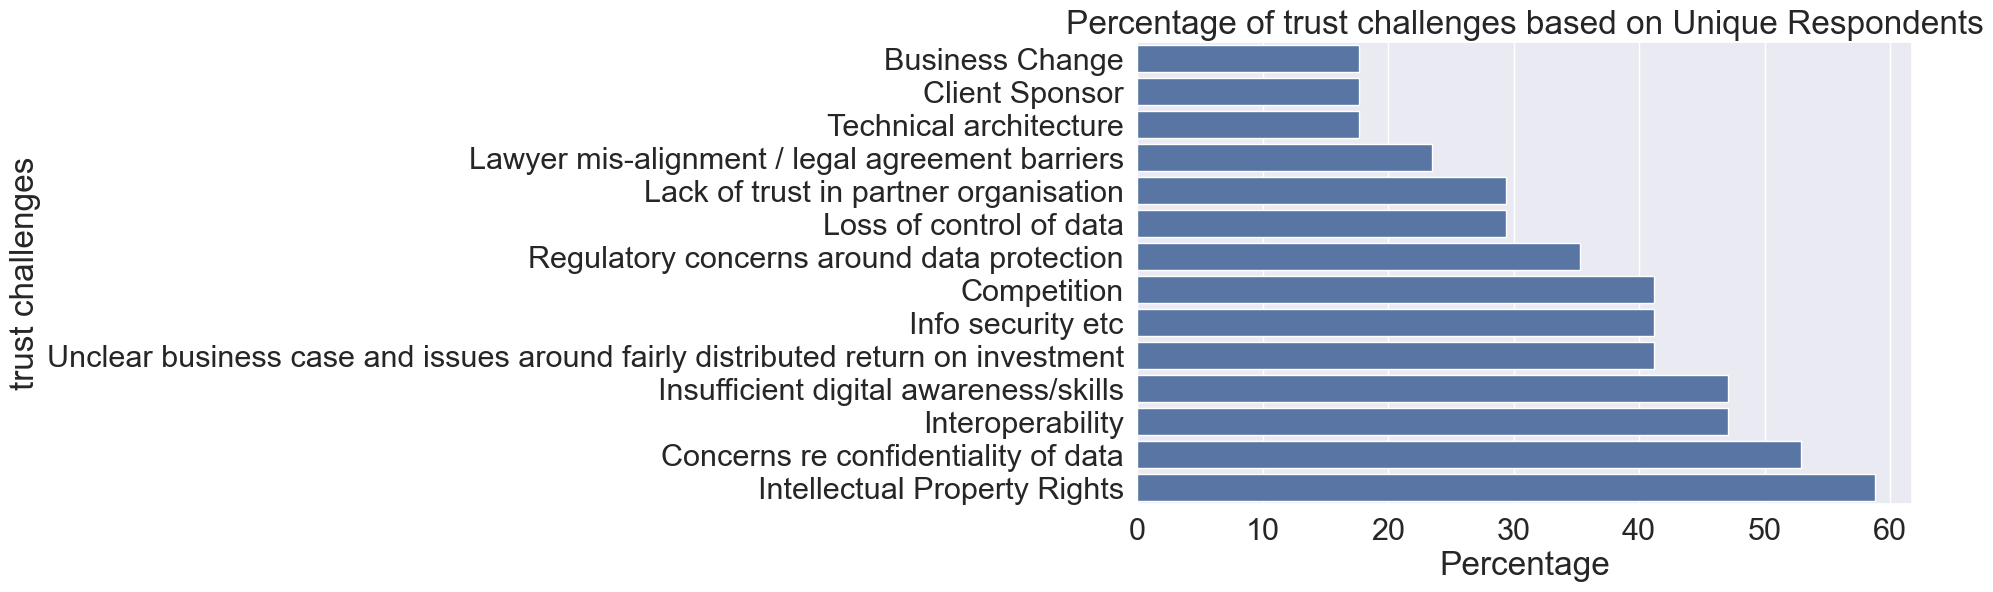

In [ ]:
# Melt columns
trust_challenge_columns = [col for col in df.columns if col.startswith('partner_trust_challenges[')]
trust_challenge_melted = melt_multiple_select(df, trust_challenge_columns, 'trust challenges',)

top_3_trust_challenges = trust_challenge_melted['trust challenges'].value_counts()[:3]
print(f'The most frequently reported challenges for partnering around connected digital twins were {top_3_trust_challenges.index.values}')

barplot(trust_challenge_melted, 'trust challenges')

## Satisfaction

## Insights Summary
- Overall Satisfaction is high. 
- **Most often** respondents **agree** that:
    - their assurance activities extend beyond checklists and are integrated into operational practices
    - the way they communicate assurance contributes to building and maintaining trust
    - they can link assurance activities to higher-level principles guiding trustwowrthiness and ethical standards
- Respondents were **most positive** about **communication** of assurance
    - among those 13 that reported dissatisfaction on some level, the most frequent response to the question around effectiveness of communication was still "agree"
- Overall, the most frequent response to **how satisfied** teams are with their assurance process was **Somewhat satisfied**
    - Among respondents with **publicly impactful DTs**, there were **fewer reports of high satisfaction**, and the most frequent response was **somewhat unsatisfied**

In [ ]:
response_options = [
            "Strongly disagree",
            "Disagree",
            "Neutral",
            "Agree",
            "Strongly agree",
        ]
sel_df = df[['integrate_assurance','communication_impact','link_assurance_activities']]
# Calculate frequencies for each column
frequencies = {col: sel_df[col].value_counts().reindex(response_options, fill_value=0) for col in sel_df.columns}

# Convert the frequencies to a DataFrame
freq_df = pd.DataFrame(frequencies)

# Set positions for the bars
bar_width = 0.25
positions = [np.arange(len(response_options)) + i * bar_width for i in range(len(sel_df.columns))]

# Create the traces
traces = [
    go.Bar(
        x=[pos for pos in pos_list],
        y=freq_df[col],
        name=col,
        width=bar_width
    ) for col, pos_list in zip(sel_df.columns, positions)
]

# Create the layout
layout = go.Layout(
    barmode='group',
    xaxis=dict(title='Response Category', tickvals=positions[0], ticktext=response_options),
    yaxis=dict(title='Frequency'),
    title='Frequency of Responses for Three Different Columns'
)

# Create and show the figure
fig = go.Figure(data=traces, layout=layout)
fig.show()


In [ ]:
df_melted = sel_df.melt(var_name='Category', value_name='Response')

# Using pd.crosstab to create the pivot-style table
df_opinion = pd.crosstab(df_melted['Category'], df_melted['Response'])
df_opinion

Response,Agree,Disagree,Neutral,Strongly agree,Strongly disagree
Category,,,,,
communication_impact,27,1,6,13,3
integrate_assurance,21,4,13,8,4
link_assurance_activities,17,5,14,12,2


In [ ]:
fig = go.Figure()
palette_left = ['Red_50','Red']
palette_right = ['Teal_50','Teal']

for i,col in enumerate(df_opinion.columns[[1,4]]):

    fig.add_trace(go.Bar(x=-df_opinion[col].values,
                         y=df_opinion.index,
                         orientation='h',
                         name=col,
                         customdata=df_opinion[col],
                         hovertemplate = "%{y}: %{customdata}",
                         marker_color=color_hex_codes.get(palette_left[i]),
                         marker_line_color='white',  
                         marker_line_width=3 ))
for i,col in enumerate(df_opinion.columns[[0,3]]):
    fig.add_trace(go.Bar(x= df_opinion[col],
                         y =df_opinion.index,
                         orientation='h',
                         name= col,
                         hovertemplate="%{y}: %{x}",
                         marker_color=color_hex_codes.get(palette_right[i]),
                         marker_line_color='white',  
                         marker_line_width=3  ))    

fig.update_layout(barmode='relative', 
                  height=400, 
                  width=700, 
                  yaxis_autorange='reversed',
                  legend_orientation ='h',
                  legend_x=-0.05, legend_y=1.1,
                  bargap=0.2,  # Increased space between the bars
                  bargroupgap=0.1,
                  xaxis=dict(showgrid=False),  
                  yaxis=dict(showgrid=False),
                  plot_bgcolor='white',  
                  paper_bgcolor='white' 
                 )
fig.show()

In [ ]:
sel_df

,integrate_assurance,communication_impact,link_assurance_activities
0,Strongly agree,Strongly agree,Strongly agree
1,Neutral,Agree,Agree
2,Neutral,Agree,Disagree
3,Neutral,Agree,Neutral
4,Neutral,Neutral,Neutral
5,Agree,Strongly agree,Strongly agree
6,Strongly agree,Agree,Neutral
7,Neutral,Neutral,Disagree
8,Neutral,Agree,Agree
9,Disagree,Neutral,Agree


In [ ]:
select_from = 'purpose_dt'
purpose_columns = [col for col in df.columns if col.startswith('purpose_dt[')]
purpose_melted = melt_multiple_select(df, purpose_columns, 'purpose_dt',)
purpose_melted = purpose_melted.merge(df[['_id','satisfaction_justification']], on='_id')

category_order = ['Very unsatisfied', 'Somewhat unsatisfied', 'Neutral','Somewhat satisfied', 'Very satisfied']
sel1 = 'Public Impact'
sel2 = 'Research and Development'
plot_val = 'satisfaction_justification'

barplot_grouped(purpose_melted, plot_val, select_from, sel1, sel2, category_order=category_order)

In [ ]:
response_options = [
            "Very unsatisfied",
            "Somewhat unsatisfied",
            "Neutral",
            "Somewhat satisfied",
            "Very satisfied",
        ]
sel_df = df[['satisfaction_justification']]
# Calculate frequencies for each column
frequencies = {col: sel_df[col].value_counts().reindex(response_options, fill_value=0) for col in sel_df.columns}

# Convert the frequencies to a DataFrame
freq_df = pd.DataFrame(frequencies)

# Set positions for the bars
bar_width = 0.25
positions = [np.arange(len(response_options)) + i * bar_width for i in range(len(sel_df.columns))]

# Create the traces
traces = [
    go.Bar(
        x=[pos for pos in pos_list],
        y=freq_df[col],
        name=col,
        width=bar_width
    ) for col, pos_list in zip(sel_df.columns, positions)
]

# Create the layout
layout = go.Layout(
    barmode='group',
    xaxis=dict(title='Response Category', tickvals=positions[0], ticktext=response_options),
    yaxis=dict(title='Frequency'),
    title = 'How satisfied are you with how your team identifies and documents requirements, actions, and decisions in your assurance process?'
)

# Create and show the figure
fig = go.Figure(data=traces, layout=layout)
fig.show()

## Gemini Principles

In [ ]:
## Overall VALUE of principles
# Mapping dictionary for shortening the responses
shorten_mapping = {
    "I've seen them but don't use them in my work.": "Seen but not used",
    "This is the first time I've heard of them.": "First time heard",
    "I've heard of them but don't know much.": "Heard but don't know much",
    "I incorporate them in my work as guidelines.": "Use as guidelines",
    "I have helped develop them.": "Helped develop"
}

# Replace the long responses with the shortened versions
df['familiarity_with_gemini_principles'] = df['familiarity_with_gemini_principles'].replace(shorten_mapping)

# Step 2: Categorize the responses into 'familiar' and 'unfamiliar' using a lambda function
df['familiarity_binary'] = df['familiarity_with_gemini_principles'].apply(
    lambda x: 'familiar' if x in ["Use as guidelines", "Seen but not used", "Helped develop"] else 'unfamiliar'
)
plot_pie_chart(df, 'familiarity_with_gemini_principles', title="Overall freq per mechanims",dpull=0)


In [ ]:
# Mapping strings to numerical values
relevance_map = {
    "Not Relevant": 0,
    "Slightly": 1,
    "Moderately": 2,
    "Very": 3,
    "Extremely Relevant": 4
}

challenge_map = {
    "Not at all challenging": 0,
    "Slightly": 1,
    "Moderately": 2,
    "Very": 3,
    "Extremely challenging": 4
}

# Create a copy of the DataFrame with only the relevance and challenge columns
relevance_challenge_columns = [col for col in df.columns if col.startswith('relevance_') or col.startswith('challenge_')]
df_gemini = df[relevance_challenge_columns].copy()

for col in df.columns:
    if col.startswith('relevance_'):
        df_gemini[col] = df_gemini[col].map(relevance_map)
    elif col.startswith('challenge_'):
        df_gemini[col] = df_gemini[col].map(challenge_map)

In [ ]:
def plot_quadrants(df, color_map, add_std=True, filename='newplot', metric='mode', cross_hair=True):    
    fig = px.scatter()
    fig.update_layout(xaxis=dict(range=[1, 3], showgrid=False), yaxis=dict(range=[2, 4], showgrid=False), 
                      plot_bgcolor='rgba(0,0,0,0)',   # Transparent plot background
                      paper_bgcolor='rgba(0,0,0,0)')

    # Add ellipses for each term to represent standard deviation, colored the same as the scatter plot points
    if add_std:
        for i, row in df.iterrows():
            term_color = color_map[row['term']]
            fig.add_shape(type="circle",
                          x0=row[f'challenge_{metric}'] - row['challenge_std'], y0=row[f'relevance_{metric}'] - row['relevance_std'],
                          x1=row[f'challenge_{metric}'] + row['challenge_std'], y1=row[f'relevance_{metric}'] + row['relevance_std'],
                          line_color='rgba(0, 0, 0, 0)',
                          fillcolor=term_color,
                          line=dict(width=0),
                          opacity=0.15)

    # Now add the scatter plot of jittered mean values on top of the shapes
    mean_scatter = px.scatter(df, x=f'challenge_{metric}', y=f'relevance_{metric}', color='term',
                              labels={f'challenge_{metric}': 'Average Challenge', 'relevance_{metric}': 'Average Relevance'},
                              color_discrete_map=color_map)
    for trace in mean_scatter.data:
        fig.add_trace(trace)
    fig.update_traces(marker=dict(size=15))

    # Add fixed quadrant lines at absolute means
    if cross_hair:
        mean_challenge = df[f'challenge_{metric}'].mean()
        mean_relevance = df[f'relevance_{metric}'].mean()
        fig.add_vline(x=mean_challenge, line=dict(color="black", width=1, dash="dash"), annotation_text=" ", annotation_position="top")
        fig.add_hline(y=mean_relevance, line=dict(color="black", width=1, dash="dash"), annotation_text=" ", annotation_position="right")
            

    fig.update_layout(plot_bgcolor='white', paper_bgcolor='white')
    import plotly.io as pio

    # Set the default renderer to export with a white background
    pio.kaleido.scope.default_format = "png"  # Ensures PNG format
    pio.kaleido.scope.default_width = 800     # Adjust as needed
    pio.kaleido.scope.default_height = 600    # Adjust as needed
    pio.kaleido.scope.default_scale = 1.5     # Adjust as needed
    pio.kaleido.scope.default_background = 'white'  # Set background to white

    # To save the figure directly with a white background
    fig.write_image(f"quadrant_gemini.png")
    fig.show()

In [ ]:
terms = [col.split('_')[1] for col in df.columns if col.startswith('relevance_')]
terms = list(set(terms))
long_df = pd.DataFrame()
for term in terms:
    term_df = df_gemini[[f'relevance_{term}', f'challenge_{term}']].copy()
    term_df.columns = ['relevance', 'challenge']
    term_df['term'] = term
    long_df = pd.concat([long_df, term_df], axis=0)
long_df['term'] = long_df['term'].replace('good', 'public good')


In [ ]:
# recode NaNs
#long_df = long_df.fillna(-1)
#long_df[long_df['relevance']==0]

In [ ]:
# Calculate the average and standard deviation for each term
# Define a custom function to compute the mode

# Assume long_df is your DataFrame
def custom_mode(series):
    mode_series = series.mode()
    if len(mode_series) == 1:
        return mode_series.iloc[0]
    else:
        return mode_series.median()
    
# Define a custom MAD function
def mad(series):
    median = series.median()
    return (series - median).abs().median()

# Compute the statistics
avg_std_ratings = long_df.groupby('term').agg({
    'relevance': ['mean', 'std', 'median', mad, lambda x: x.quantile(0.75) - x.quantile(0.25), custom_mode],
    'challenge': ['mean', 'std', 'median', mad, lambda x: x.quantile(0.75) - x.quantile(0.25), custom_mode]
}).reset_index()

# Rename the columns for better readability
avg_std_ratings.columns = ['term', 'relevance_mean', 'relevance_std', 'relevance_median', 'relevance_mad', 'relevance_iqr', 'relevance_mode',
                    'challenge_mean', 'challenge_std', 'challenge_median', 'challenge_mad', 'challenge_iqr', 'challenge_mode']



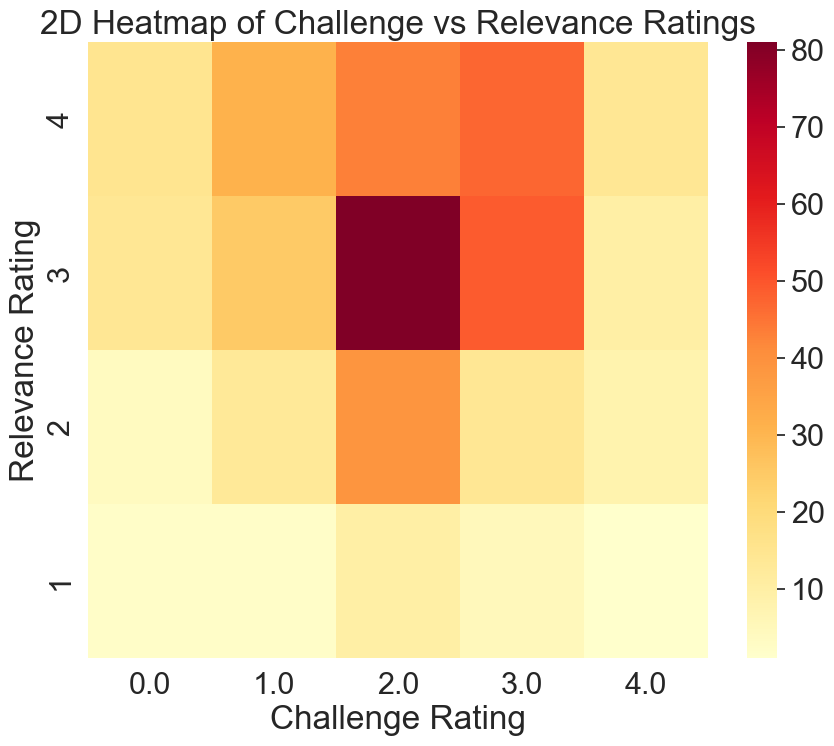

In [ ]:
# Assuming long_df is already defined with columns 'term', 'relevance', and 'challenge'

# Create a contingency table with challenge ratings on one dimension and relevance ratings on another
contingency_table = pd.crosstab(long_df['relevance'], long_df['challenge'])

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(contingency_table, annot=False, fmt="d", cmap="YlOrRd", cbar=True)
plt.title('2D Heatmap of Challenge vs Relevance Ratings')
plt.xlabel('Challenge Rating')
plt.ylabel('Relevance Rating')
plt.gca().invert_yaxis()
plt.show()

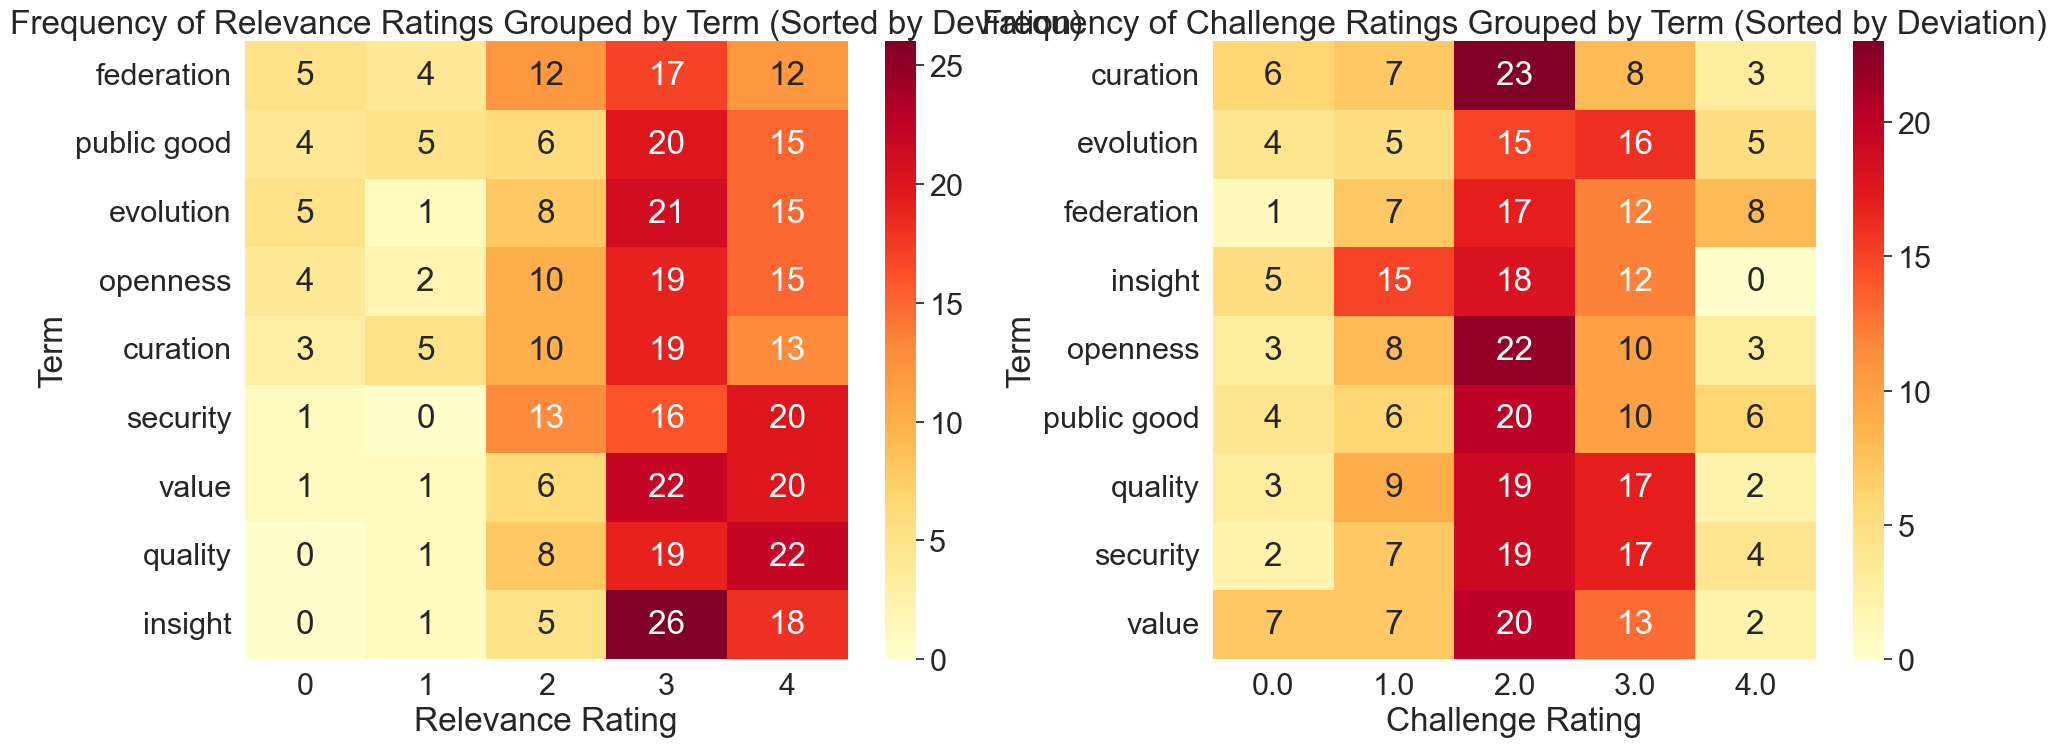

In [ ]:
# Count frequency of each unique item in 'relevance' and 'challenge' columns grouped by 'term'
relevance_counts = long_df.groupby('term')['relevance'].value_counts().unstack(fill_value=0)
challenge_counts = long_df.groupby('term')['challenge'].value_counts().unstack(fill_value=0)


# Reindex the counts to match the sorted terms
sort_relevance_std = avg_std_ratings.sort_values(by='relevance_std', ascending=False)['term']
relevance_counts = relevance_counts.reindex(sort_relevance_std)
sort_challenge_std = avg_std_ratings.sort_values(by='challenge_std', ascending=False)['term']
#challenge_counts = challenge_counts.reindex(sorted_terms)

# sort by split opinions
#challenge_sort = pd.DataFrame(challenge_counts).apply(lambda x: abs((x.iloc[0]+x.iloc[1]) - (x.iloc[3]+x.iloc[4])),axis=1).sort_values().index
#challenge_counts=challenge_counts.reindex(idx_sort)
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

# Plot the heatmap for relevance
sns.heatmap(relevance_counts, annot=True, fmt="d", cmap="YlOrRd", cbar=True, ax=axes[0])
axes[0].set_title('Frequency of Relevance Ratings Grouped by Term (Sorted by Deviation)')
axes[0].set_xlabel('Relevance Rating')
axes[0].set_ylabel('Term')

# Plot the heatmap for challenge
sns.heatmap(challenge_counts, annot=True, fmt="d", cmap="YlOrRd", cbar=True, ax=axes[1])
axes[1].set_title('Frequency of Challenge Ratings Grouped by Term (Sorted by Deviation)')
axes[1].set_xlabel('Challenge Rating')
axes[1].set_ylabel('Term')

plt.tight_layout()
plt.show()

In [ ]:

# add jitter once
#jitter_strength=0.3
#avg_std_ratings['challenge_mean'] = avg_std_ratings['challenge_mean'] + np.random.uniform(-jitter_strength, jitter_strength, size=len(avg_std_ratings))
#avg_std_ratings['relevance_mean'] = avg_std_ratings['relevance_mean'] + np.random.uniform(-jitter_strength, jitter_strength, size=len(avg_std_ratings))


#colors = px.colors.qualitative.Plotly
#color_map = {term: colors[i % len(colors)] for i, term in enumerate(avg_std_ratings['term'].unique())}

color_map = {
    'value': '#FF6347',     # Warm - Red 
    'insight': '#FFA500',   # Warm - Orange 
    'quality': '#FFD700',   # Warm - Yellow
    'federation': '#1E90FF',# Cool - DodgerBlue
    'security': '#4169E1',  # Cool - RoyalBlue
    'evolution': '#9370DB', # Cool - MediumPurple
    'openness': '#32CD32',  # Other - LimeGreen
    'public good': '#8B4513',      # Other - SaddleBrown
    'curation': '#FFDAB9'   # Other - PeachPuff
}

plot_quadrants(avg_std_ratings, color_map, add_std=False, filename='2D_all_principles_mean.svg', metric='mean')

In [ ]:
sort_relevance_std.tolist()

['federation',
 'public good',
 'evolution',
 'openness',
 'curation',
 'security',
 'value',
 'quality',
 'insight']

/var/folders/pf/qtjbydz94vv7r4pq8q1wxq980000gr/T/ipykernel_4580/3958671993.py:12: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/pf/qtjbydz94vv7r4pq8q1wxq980000gr/T/ipykernel_4580/3958671993.py:17: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



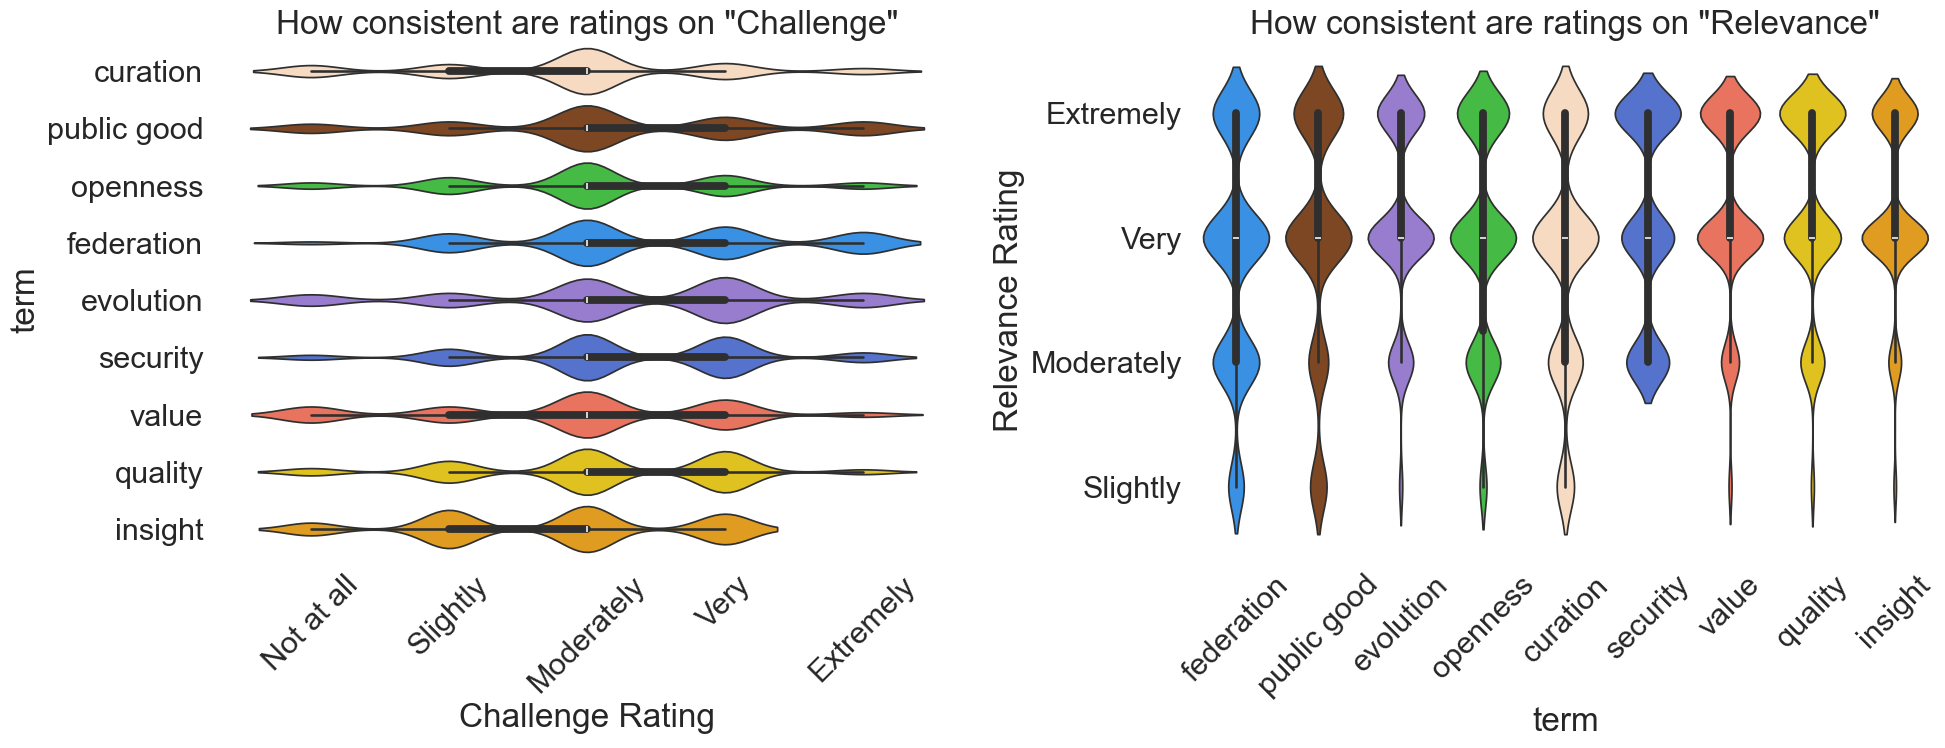

In [ ]:
long_df = long_df[long_df['challenge']>=0]
sns.set(font_scale=2)

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

# Plot the violin plot for challenge
sns.violinplot(x='challenge', y='term', data=long_df, ax=axes[0], hue='term', bw_method=0.2, order=['curation','public good','openness','federation','evolution','security','value','quality','insight'], palette=color_map)
axes[0].set_title('How consistent are ratings on "Challenge"')
axes[0].set_xlabel('Challenge Rating')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_xticklabels(['','Not at all','Slightly','Moderately','Very','Extremely'])
# Plot the violin plot for relevance
sns.violinplot(x='term', y='relevance', data=long_df, ax=axes[1],hue='term',  bw_method=0.2, order=sort_relevance_std.tolist(),  palette=color_map)
axes[1].set_title('How consistent are ratings on "Relevance"')
axes[1].set_ylabel('Relevance Rating')
axes[1].set_yticklabels(['','Slightly','Moderately','Very','Extremely'])

axes[1].tick_params(axis='x', rotation=45)
# Remove the background color from the plots
for ax in axes:
    ax.set_facecolor('none')  # Set the background color of the plot area to none


plt.tight_layout()
plt.show()


In [ ]:
df_relevance = long_df.groupby(['term', 'relevance']).size().unstack(fill_value=0)
inverse_map = {v: k for k,v in relevance_map.items()}
df_relevance.rename(columns=inverse_map,inplace=True)
df_relevance['sum'] = df_relevance['Extremely Relevant'] + df_relevance['Very']
df_relevance = df_relevance.sort_values(by=['sum'],ascending=False)

In [ ]:
fig = go.Figure()
palette_left = ['Teal_50','Teal']
palette_right = ['Orange_75','Orange_50','Orange']

for i,col in enumerate(df_relevance.columns[[3,4]]):
    fig.add_trace(go.Bar(x=-df_relevance[col].values,
                         y=df_relevance.index,
                         orientation='h',
                         name=col,
                         customdata=df_relevance[col],
                         hovertemplate = "%{y}: %{customdata}",
                         marker_color=color_hex_codes.get(palette_left[i]),
                         marker_line_color='white',  
                         marker_line_width=3  ))
for i,col in enumerate(df_relevance.columns[[2,1,0]]):
    fig.add_trace(go.Bar(x= df_relevance[col],
                         y =df_relevance.index,
                         orientation='h',
                         name= col,
                         hovertemplate="%{y}: %{x}",
                         marker_color=color_hex_codes.get(palette_right[i]),
                         marker_line_color='white',  
                         marker_line_width=3  ))  
    


fig.update_layout(barmode='relative', 
                  height=400, 
                  width=700, 
                  yaxis_autorange='reversed',
                  legend_orientation ='h',
                  legend_x=-0.05, legend_y=1.1,
                  bargap=0.2,  # Increased space between the bars
                  bargroupgap=0.1,
                  plot_bgcolor='white',  
                  paper_bgcolor='white' 
                 )
fig.show()


In [ ]:
df_challenge = long_df.groupby(['term', 'challenge']).size().unstack(fill_value=0)
inv_challenge_map = {v:k for k,v in challenge_map.items()}
df_challenge.rename(columns=inv_challenge_map,inplace=True)
#df_challenge['sum'] = df_challenge['Extremely challenging'] + df_challenge['Very']
#df_challenge = df_challenge.sort_values(by=['sum'],ascending=False)
df_challenge = df_challenge.reindex(df_relevance.index)

In [ ]:
df_challenge['sum'] = df_challenge['Extremely challenging'] + df_challenge['Very']
df_challenge = df_challenge.sort_values(by=['sum'],ascending=False)

In [ ]:
fig = go.Figure()
palette_left = ['Blue_50','Blue_25']
palette_right = ['Purple_75','Purple_50','Purple']

for i,col in enumerate(df_challenge.columns[[3,4]]):
    fig.add_trace(go.Bar(x=-df_challenge[col].values,
                         y=df_challenge.index,
                         orientation='h',
                         name=col,
                         customdata=df_challenge[col],
                         hovertemplate = "%{y}: %{customdata}",
                         marker_color=color_hex_codes.get(palette_left[i]),
                         marker_line_color='white',  
                         marker_line_width=3 ))
for i,col in enumerate(df_challenge.columns[[2,1,0]]):
    fig.add_trace(go.Bar(x= df_challenge[col],
                         y =df_challenge.index,
                         orientation='h',
                         name= col,
                         hovertemplate="%{y}: %{x}",
                         marker_color=color_hex_codes.get(palette_right[i]),
                         marker_line_color='white',  
                         marker_line_width=3  ))    

fig.update_layout(barmode='relative', 
                  height=400, 
                  width=700, 
                  yaxis_autorange='reversed',
                  legend_orientation ='h',
                  legend_x=-0.05, legend_y=1.1,
                  bargap=0.2,  # Increased space between the bars
                  bargroupgap=0.1,
                  xaxis=dict(showgrid=False),  
                  yaxis=dict(showgrid=False),
                  plot_bgcolor='white',  
                  paper_bgcolor='white' 
                 )
fig.show()